# Analyzing images
This notebook will build on what we did in the training notebook. First, let us consider the following experiment: We have a group of TRAP2 mice, and we are interested in studying whether the basolateral amygdala (BLA) is involved in two different behavioral tasks. To do so, we induced the expression of tdTomato fluorescent protein in TRAP2 mice by injecting 4OH-tamoxifen during the first behavioral task, labeling the cells activated during this period. After a week of expression, we performed the second different behavioral task, perfused the mice, and performed immunological labeling of cFos protein expression. We took photos of the BLA with a fluorescent microscope, segmented the BLA region, and saved the TIFF images in the folders `tdt` and `cfos`.


We will start by importing the necessary packages for our analysis, including the functions from `cellradar`. Ensure you have correctly installed `cellradar` in your Conda environment following the instructions in [README.md](../README.md) and that you are running this notebook with this environment (top right corner of the notebook if you are using VSCode).

In [1]:
from pathlib import Path
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from cellradar.main import analyze
from cellradar.predicting import colocalize

2024-08-15 14:10:16.910657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyzing images with a trained model
In this first example, we will use a pre-trained model to predict tdTomato-positive cells and want to use it to identify positive cells in a new set of images. We will first load the model and establish the path where we store the images to analyze.

In [2]:
with open("./best_model_svm.pkl", "rb") as file:
    best_model = pkl.load(file)
tdt_folder = Path("./sample_data/tdt")

base.py (348): Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
base.py (348): Trying to unpickle estimator PCA from version 1.2.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
base.py (348): Trying to unpickle estimator SVC from version 1.2.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
base.py (348): Trying to unpickle estimator Pipeline from version 1.2.0 when using version 1.3.2. This might lead to

The `analyze` function takes three arguments: `image_folder`, `cmap`, and `best_model`. To obtain more information, we can read the docstring of the function:

In [ ]:
help(analyze)

We will run the function `analyze` using the defined path to the images and the uploaded machine-learning model. The selected `cmap` is "Reds" as the tdTomato protein glows in red under the microscope.

In [3]:
analyze(tdt_folder, 'Reds', best_model)

Found model '2D_versatile_fluo' for 'StarDist2D'.


2024-08-15 14:10:36.014082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Applying prediction model: 100%|██████████| 5/5 [00:07<00:00,  1.50s/image]


We have just predicted the tdTomato-positive cells in the sample dataset! In the output folder, named `tdt_analysis`, we have the results of the analysis:

- `labelled_images`: the rendered images comparing the original image with the identified tdTomato-positive cells overlapped.
- `rois_processed`: the identified tdTomato-positive cells after being processed by our machine-learning model.
- `rois_raw`: the resulting segmented Regions of interest (ROIs) that will be the input for the machine-learning model. 
- `counts`: the number of predicted cells for each image.

We can examine the results checking the results table and opening an image:

In [4]:
pd.read_csv("./sample_data/tdt_analysis/counts.csv")

,file_name,num_cells
0,C2-34454_B2_10X_BLA_002,15
1,C2-34454_B2_10X_BLA_001,27
2,C2-34453_B1_10X_BLA_001,9
3,C2-34453_B1_10X_BLA_002,20
4,C2-34454_B2_10X_BLA_,16


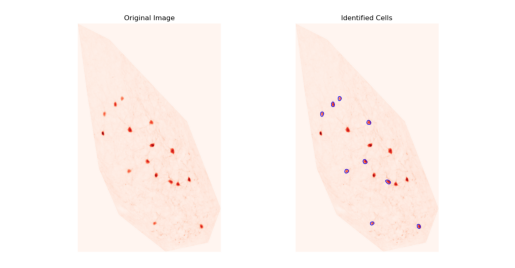

In [5]:
pil_image = Image.open("./sample_data/tdt_analysis/labelled_images/C2-34453_B1_10X_BLA_001.png")
plt.imshow(pil_image)
plt.axis('off')
plt.show()

## Analyzing images without a trained model
Sometimes, we do not have a trained machine learning model because there are many cells in the images, so it would be time-consuming, or maybe because we are just exploring the dataset before training an actual model. In these cases, it is possible to perform an analysis without specifying the `best_model` argument on the function `analyze`. You will notice that the results are only sometimes accurate; therefore, I recommend training a model.

In [6]:
cfos_folder = Path("./sample_data/cfos")

In [7]:
analyze(cfos_folder, 'Greens')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Applying prediction model: 100%|██████████| 5/5 [00:07<00:00,  1.47s/image]


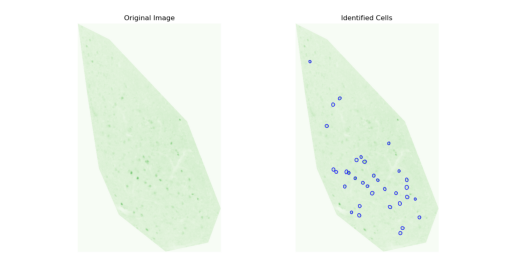

In [9]:
pd.read_csv("./sample_data/cfos_analysis/counts.csv")

pil_image = Image.open("./sample_data/cfos_analysis/labelled_images/C3-34453_B1_10X_BLA_001.png")
plt.imshow(pil_image)
plt.axis('off')
plt.show()

# Analyzing colocalization

We may sometimes work with images in which cells express multiple markers. For instance, in the provided example dataset, cells can be tdTomato-positive and cFos-positive. In this case, analyzing which cells express both markers simultaneously makes sense. To do so, we first have to analyze both markers separately (as we have already done) and call the function `colocalize`.

In [10]:
cfos_rois_processed = Path('./sample_data/cfos_analysis/rois_processed')
cfos_images = Path('./sample_data/cfos')
tdt_rois_processed = Path('./sample_data/tdt_analysis/rois_processed')
tdt_images = Path('./sample_data/tdt')

In [12]:
colocalize(cfos_rois_processed, cfos_images, tdt_rois_processed, tdt_images)

Processing images: 100%|██████████| 5/5 [00:06<00:00,  1.20s/image]


The analysis results are automatically saved in the folder named `colocalization_cfos_tdt`.

In [ ]:
pd.read_csv("./sample_data/colocalization_cfos_tdt/colocalization_results.csv")

pil_image = Image.open("./sample_data/colocalization_cfos_tdt/labelled_images/C3-34453_B1_10X_BLA_001.png")
plt.imshow(pil_image)
plt.axis('off')
plt.show()

In [ ]:
# path = image_folder.parent / 'features.csv'
# with open(path, 'rb') as file:
#     best_model = pkl.load(file)
# df = pd.read_csv(path, index_col=None)
# df = df.drop(columns=['Unnamed: 0'])
# X = X_test
# y = y_test

In [ ]:
# df = pd.read_csv("C:/Users/mcanela/Desktop/sample_jose/tdt_analysis_with_model/counts.csv")
# split_df = df["file_name"].str.split("_", expand=True)
# df["id"] = split_df[0]
# grouped_df = df.groupby("id")["num_cells"].mean().reset_index()
# grouped_df.to_excel("C:/Users/mcanela/Desktop/sample_jose/counts_grouped.xlsx", index=False)


# split_df = df["file_name"].str.split("_", expand=True)
# df[["group", "id", "brain", "replica"]] = split_df
# grouped_df = df.groupby(["group", "id", "brain"])["cells_per_squared_mm"].mean().reset_index()
# grouped_df.columns = ["group", "id", "brain", "mean_cells_per_squared_mm"]
# grouped_df.to_excel(os.path.join(output_folder, "results_friendly.xlsx"), index=False)